In [260]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
from skimage.feature import hog

import sys

images = glob.glob('./imgdb/*/*/*.png')
cars = []
notcars = []

for image in images:

    if 'non-vehicles' in image:
        notcars.append(image)
    else:
        cars.append(image)
        
print("total car images available:", len(cars))
print("total non-car images available:", len(notcars))

total car images available: 8792
total non-car images available: 8968


In [261]:
# when developing classifier, allow for shortening our dataset
# by setting this to smaller values, e.g. 100
NUM_CARS = len(cars)
NUM_NOTCARS = len(notcars)

ORIENT = 8
PIX_PER_CELL = 8
CELL_PER_BLOCK = 2
HOG_CHANNEL = 0

def normalize_img(img):
    return (255 * img/np.max(img)).astype(np.uint8)

# preprocess RGB image before submitting it for HOG extraction
def pre_hog(img):
    #return img[:,:,HOG_CHANNEL]
    return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)[:,:,0]

def get_hog_features(img, vis=False):
    return hog(img,
               orientations=ORIENT, 
               pixels_per_cell=(PIX_PER_CELL, PIX_PER_CELL),
               cells_per_block=(CELL_PER_BLOCK, CELL_PER_BLOCK), 
               transform_sqrt=False,
               visualise=vis, 
               feature_vector=True)

def get_imgs_and_features(source, ind):
    # Read in the image
    img = mpimg.imread(source[ind])
    preimg = pre_hog(img)
    features, hog_img = get_hog_features(preimg,
                            vis=True)
    
    return img, preimg, hog_img, features

def get_features_only(filename):
    img = mpimg.imread(filename)
    return get_hog_features(pre_hog(img), vis=False)

def make_mosaic():
    # get a few images of cars and non-cars, and stack them
    for name, source in [('mosaic_cars_experiment.png', cars), ('mosaic_noncars_experiment.png', notcars)]:
        grays = []
        hog_imgs = []
        for ind in range(20):
            img, gray, hog_img, features = get_imgs_and_features(source, ind)
            grays.append(normalize_img(gray))
            hog_imgs.append(normalize_img(hog_img))

        mosaic = np.vstack((np.hstack(grays), np.hstack(hog_imgs)))
        cv2.imwrite(name, mosaic)
        
make_mosaic()
    


In [262]:
# now build the training and testing sets
car_feats = [get_features_only(f) for f in cars[:NUM_CARS]]
notcar_feats = [get_features_only(f) for f in notcars[:NUM_NOTCARS]]
X = np.vstack((car_feats, notcar_feats))


In [263]:
from sklearn.preprocessing import StandardScaler

X = np.vstack((car_feats, notcar_feats)).astype(np.float64)
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

y = np.hstack((np.ones(NUM_CARS), np.zeros(NUM_NOTCARS)))

In [264]:
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC

X_train, X_test, y_train, y_test = train_test_split(
     scaled_X, y, test_size=0.2)

svc = LinearSVC(C=0.01)
svc.fit(X_train, y_train)

print("Training accuracy: ", svc.score(X_train, y_train))
print("Test accuracy: ", svc.score(X_test, y_test))

Training accuracy:  0.987964527027
Test accuracy:  0.955518018018


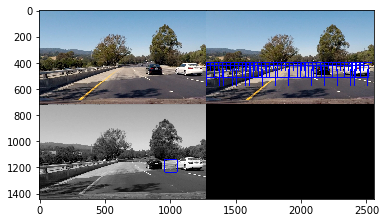

In [279]:
from scipy.ndimage.measurements import label
%matplotlib inline

# Ok, time to slide those windows.
BOX_COLOR = (0,0,255)
HEAT_THRESH = 3
MAXX = 1280
MAXY = 720

DECISION_THRESH = 0.2

MIN_HEATBOX_WIDTH = 30
MIN_HEATBOX_HEIGHT = 30

FADING_RATE = 0.9
global global_heatmap

global_heatmap = None

box_templates = [
    (0, 400, 64 , 30),
    (0, 420, 96 , 60),
    (0, 450, 128, 100),
]

def make_boxes():
    boxes = []
    for bt in box_templates:
        x0, y0, size, step = bt
        x, y = x0, y0
        while x + size < MAXX and y + size < MAXY:
            boxes.append(((x, y), (x + size, y+size)))
            x += step
    return boxes

def make_3ch_img(channel):
    res = np.zeros((MAXY, MAXX, 3))
    scale = np.max(channel)
    res[:,:,0] = 255. * channel / scale
    res[:,:,1] = 255. * channel / scale
    res[:,:,2] = 255. * channel / scale
    return res.astype(np.uint8)

def draw_boxes(img, boxes):
    for p1, p2 in boxes:
        cv2.rectangle(img, p1, p2, BOX_COLOR, 4)

def slide_and_search(img, boxes):
    boxes_predicted = []
    for p1, p2 in boxes:
        x1, y1 = p1
        x2, y2 = p2
        cropped = cv2.resize(img[y1:y2, x1:x2], (64, 64))
        ftr = get_hog_features(cropped, vis=False)
        ftr = X_scaler.transform(np.array(ftr).reshape(1, -1))
        if svc.decision_function(ftr) > DECISION_THRESH:
            boxes_predicted.append((p1, p2))
            heatmap[y1:y2, x1:x2] += 1
    return boxes_predicted

def make_heatmap(boxes):
    heatmap = np.zeros((MAXY, MAXX)).astype(np.float)
    for p1, p2 in boxes:
        x1, y1 = p1
        x2, y2 = p2
        heatmap[y1:y2, x1:x2] += 1
    heatmap = np.clip(heatmap, 0, 255)

    return heatmap

def get_heat_boxes(labels):
    boxes = []
    for ind in range(1, labels[1] + 1):
        nonzero = (labels[0] == ind).nonzero()
        xs = np.array(nonzero[1])
        ys = np.array(nonzero[0])
        p1 = (np.min(xs), np.min(ys))
        p2 = (np.max(xs), np.max(ys))
        
        if p2[0] - p1[0] >= MIN_HEATBOX_WIDTH and p2[1] - p1[1] >= MIN_HEATBOX_HEIGHT:
            boxes.append((p1, p2))
        
    return boxes


def expand_heat_boxes(heat_boxes, cars_found):
    expanded_boxes = []
    for ph1, ph2 in heat_boxes:
        xh1, yh1 = ph1
        xh2, yh2 = ph2
        xh1, xh2 = min(xh1, xh2), max(xh1, xh2)
        yh1, yh2 = min(yh1, yh2), max(yh1, yh2)

        xf1, yf1, xf2, yf2 = xh1, yh1, xh2, yh2

        for pc1, pc2 in cars_found:
            xc1, yc1 = pc1
            xc2, yc2 = pc2

            xc1, xc2 = min(xc1, xc2), max(xc1, xc2)
            yc1, yc2 = min(yc1, yc2), max(yc1, yc2)

            # if the found car box intersects the heat box,
            # expand the final box to the found car box

            # skip if no intersect
            if xc2 < xh1 or xc1 > xh2 or yc2 < yh1 or yc1 > yh2:
                continue
            # expand
            if xc1 < xf1:
                xf1 = xc1
            if yc1 < yf1:
                yf1 = yc1

            if xc2 > xf2:
                xf2 = xc2
            if yc2 > yf2:
                yf2 = yc2
        expanded_boxes.append(((xf1, yf1), (xf2, yf2)))
    return expanded_boxes

def detect_vehicles(img):
    boxes = make_boxes()
    box_img = np.copy(img)
    draw_boxes(box_img, boxes)
    
    global global_heatmap

    pre_hog_img = pre_hog(img)
    cars_found = slide_and_search(pre_hog_img, boxes)

    recog_img = make_3ch_img(pre_hog_img)
    draw_boxes(recog_img, cars_found)

    heatmap = make_heatmap(cars_found)
    if global_heatmap is not None:
        heatmap = FADING_RATE * global_heatmap + heatmap
    
    # preserve global heatmap before thresholding
    global_heatmap = np.copy(heatmap)
    
    # accumulate global heatmap before we threshold it    
    heatmap[heatmap < HEAT_THRESH] = 0
    
    heat_img = make_3ch_img(heatmap)

    labels = label(heatmap)

    heat_boxes = get_heat_boxes(labels)  
    draw_boxes(heat_img, heat_boxes)

    # now, expand the heat boxes to the bounding boxes of 
    # found cars that intersect the heat boxes
    final_boxes = expand_heat_boxes(heat_boxes, cars_found)

    draw_boxes(img, final_boxes)

    final_img = np.vstack((np.hstack((img, box_img)), 
                          np.hstack((recog_img, heat_img)),
                          # np.hstack((make_3ch_img(pre_hog_img), make_3ch_img(full_hog_img)))
                         ))
    
    return final_boxes, final_img

img = mpimg.imread('./test_images/test4.jpg')
final_boxes, final_img = detect_vehicles(img)

mpimg.imsave('final_img.jpg', final_img)
plt.imshow(final_img)

def full_pipeline(img):
    boxes, img = detect_vehicles(img)
    return img


In [282]:
import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML

global global_heatmap
global_heatmap = None

vid = VideoFileClip("./project_video.mp4") #.subclip(30,45)
lane_vid = vid.fl_image(full_pipeline) 
%time lane_vid.write_videofile("./project_video_out.mp4", audio=False)


[MoviePy] >>>> Building video ./project_video_out.mp4
[MoviePy] Writing video ./project_video_out.mp4





  0%|          | 0/1261 [00:00<?, ?it/s]


  0%|          | 1/1261 [00:00<03:23,  6.19it/s]


  0%|          | 2/1261 [00:00<03:27,  6.08it/s]


  0%|          | 3/1261 [00:00<03:24,  6.16it/s]


  0%|          | 4/1261 [00:00<03:23,  6.16it/s]


  0%|          | 5/1261 [00:00<03:19,  6.30it/s]


  0%|          | 6/1261 [00:00<03:17,  6.37it/s]


  1%|          | 7/1261 [00:01<03:16,  6.39it/s]


  1%|          | 8/1261 [00:01<03:13,  6.47it/s]


  1%|          | 9/1261 [00:01<03:13,  6.48it/s]


  1%|          | 10/1261 [00:01<03:12,  6.50it/s]


  1%|          | 11/1261 [00:01<03:11,  6.54it/s]


  1%|          | 12/1261 [00:01<03:11,  6.54it/s]


  1%|          | 13/1261 [00:02<03:10,  6.55it/s]


  1%|          | 14/1261 [00:02<03:08,  6.62it/s]


  1%|          | 15/1261 [00:02<03:12,  6.46it/s]


  1%|▏         | 16/1261 [00:02<03:13,  6.43it/s]


  1%|▏         | 17/1261 [00:02<03:12,  6.45it/s]


  1%|▏         | 18/1261 [00:02<03:12,  6.45it/s]


  2%|▏         | 19/1261 [0

[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_out.mp4 

CPU times: user 3min 59s, sys: 8.32 s, total: 4min 7s
Wall time: 4min 2s


In [255]:
svc

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [277]:
img = mpimg.imread('./test_images/test4.jpg')
img = pre_hog(img)
ftrs = []

boxes_predicted = []
for p1, p2 in boxes:
    x1, y1 = p1
    x2, y2 = p2
    cropped = cv2.resize(img[y1:y2, x1:x2], (64, 64))
    ftr = get_hog_features(cropped, vis=False)
    ftr = X_scaler.transform(np.array(ftr).reshape(1, -1))
    
    if svc.decision_function(ftr) > 0.2:
        boxes_predicted.append((p1, p2))
        heatmap[y1:y2, x1:x2] += 1
        ftrs.append(ftr)


In [278]:
boxes_predicted

[((960, 420), (1056, 516))]

In [271]:
ftrs

[array([[ 1.48330267,  1.5600977 ,  0.70460595, ..., -0.65419957,
         -0.7344174 , -0.56434651]]),
 array([[ 0.0464284 , -0.58011062, -0.56016453, ...,  0.41600228,
         -0.49263491, -0.56434651]]),
 array([[-0.94973099, -0.33535502, -0.80283611, ..., -0.18190743,
          0.17393531, -0.56434651]])]

In [272]:
svc.predict(ftrs[0])

array([ 1.])

In [275]:
svc.decision_function(ftrs[2])

array([ 0.34134661])